# 北京二手房房价分析与预测

作者：xiaoyu

时间：2018.4.11

### 项目简介
本项目根据个人需求进行北京二手房信息的数据分析，通过数据分析观察住房特征规律，利用机器学习模型进行简单的预测。
### 数据源
通过爬虫爬取第三方房屋中间商网站（链家和安居客）获取数据源，仅供学习使用。
>注：爬虫源代码见`spiders`文件夹。

### 目的
北京房价是最受关注的话题。因此，本项目以研究北京二手房房价为目的，对二手房房价进行数据分析，并希望能对未来房价进行预测（仅供参考）。
- 统计北京各区域二手房房价情况
- 统计北京各区域二手房数量
- 统计西城区、东城区和海淀区各地方二手房房价
- 统计房价与房屋面积区段的房屋数量
- 预测北京二手房房价

### 技术和工具
本项目以Python语言编程完成从爬取，数据分析，到预测。

- 爬虫工具：`scrapy` ，`beautifulsoup`
- 数据分析：`pandas`，`numpy`，`matplolib`
- 机器学习：`sklearn`


## 1. 数据导入和清洗

### 导入链家数据集

In [5]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

# 检查你的Python版本
from sys import version_info
if version_info.major != 3:
    raise Exception('请使用Python 3 来完成此项目')
    
%matplotlib inline

# 导入链家二手房数据
lianjia_df = pd.read_csv('lianjia.csv')
display(lianjia_df.head())

# 删除没用的列,为了与安居客数据合并
to_drop = ['Id', 'Direction', 'Elevator', 'Renovation']
lianjia_df_clean = lianjia_df.drop(to_drop, axis=1)

# 重新摆放列位置
columns = ['Region', 'District', 'Garden', 'Layout', 'Floor', 'Year', 'Size', 'Price']
lianjia_df_clean = pd.DataFrame(lianjia_df_clean, columns = columns)

lianjia_total_num = lianjia_df_clean['Floor'].count()
print('链家数据集总数量为: ' + str(lianjia_total_num))

,Direction,District,Elevator,Floor,Garden,Id,Layout,Price,Region,Renovation,Size,Year
0,东西,灯市口,NaN,6,锡拉胡同21号院,101102647043,3室1厅,780.0,东城,精装,75.0,1988
1,南北,东单,无电梯,6,东华门大街,101102650978,2室1厅,705.0,东城,精装,60.0,1988
2,南西,崇文门,有电梯,16,新世界中心,101102672743,3室1厅,1400.0,东城,其他,210.0,1996
3,南,崇文门,NaN,7,兴隆都市馨园,101102577410,1室1厅,420.0,东城,精装,39.0,2004
4,南,陶然亭,有电梯,19,中海紫御公馆,101102574696,2室2厅,998.0,东城,精装,90.0,2010


链家数据集总数量为: 23677


### 导入安居客数据集

In [2]:
# 导入安居客二手房数据
anjuke_df = pd.read_csv('anjuke.csv')
display(anjuke_df.head())
#清洗数据，重新摆放列位置
anjuke_df['District'] = anjuke_df['Region'].str.extract(r'.+?-(.+?)-.+?', expand=False)
anjuke_df['Region'] = anjuke_df['Region'].str.extract(r'(.+?)-.+?', expand = False)
anjuke_df = pd.DataFrame(anjuke_df, columns = ['Region', 'District', 'Garden', 'Layout',
                                               'Floor', 'Year', 'Size', 'Price'])

anjuke_total_num = anjuke_df['Floor'].count()
print('安居客数据集总数量为: ' + str(anjuke_total_num))

,Floor,Garden,Layout,Price,Region,Size,Year
0,25,兴达公寓,2室2厅,107.0,通州-马驹桥-科,76,2017
1,13,中铁华侨城和园,4室2厅,750.0,大兴-瀛海镇-公,136,2017
2,6,北营房小区,3室1厅,600.0,西城-阜成门-北,66,1988
3,22,首开璞瑅,3室2厅,698.0,丰台-方庄-方,102,2017
4,3,丽京花园,2室2厅,613.0,顺义-天竺-首,153,1999


安居客数据集总数量为: 3000


### 数据集合并

In [6]:
# 将链家数据集与安居客数据集合并
df = pd.merge(lianjia_df_clean, anjuke_df, how='outer')
df['PriceMs'] = df['Price']/df['Size']

# 对汇总数据再次清洗
df.dropna(how='any')
df.drop_duplicates(keep='first', inplace=True)
# 一些别墅的房屋单价有异常，删选价格少于25万一平的
df = df.loc[df['PriceMs']<25]

total_num = anjuke_total_num + lianjia_total_num
df_num = df['Floor'].count()
drop_num = total_num - df_num

print('合并后数据集总数量为: ' + str(total_num))
print('去重后数据集总数量为: ' + str(df_num))
print('清除重复数据量为：' + str(drop_num))

合并后数据集总数量为: 26677
去重后数据集总数量为: 24281
清除重复数据量为：2396


## 2.数据可视化分析

### 北京各区域二手房房价均值对比 & 二手房数量对比

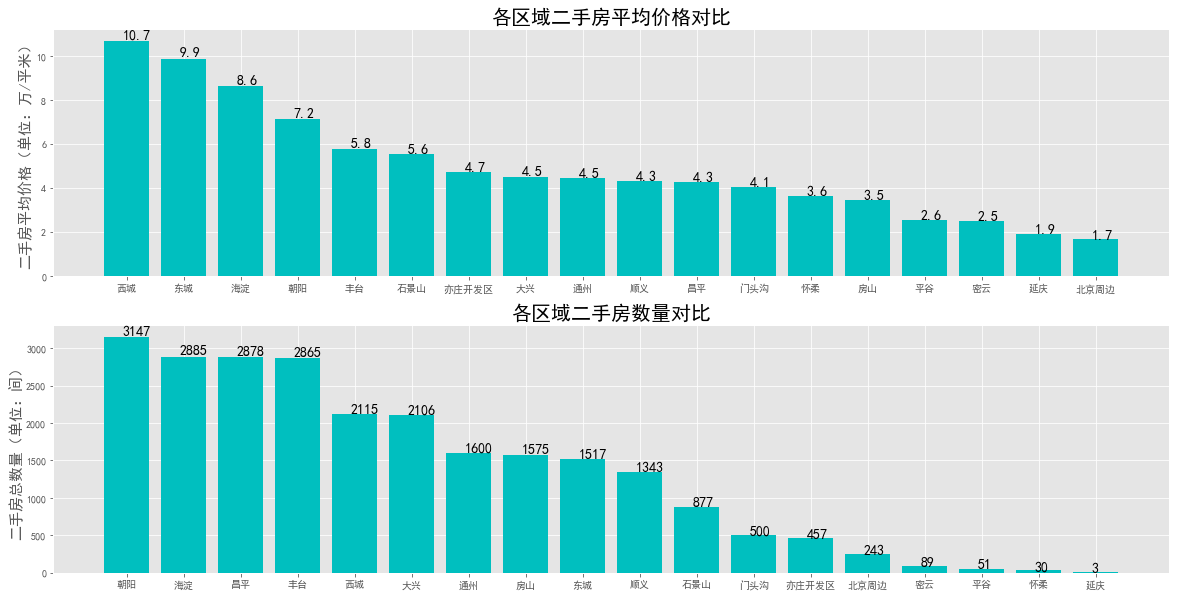

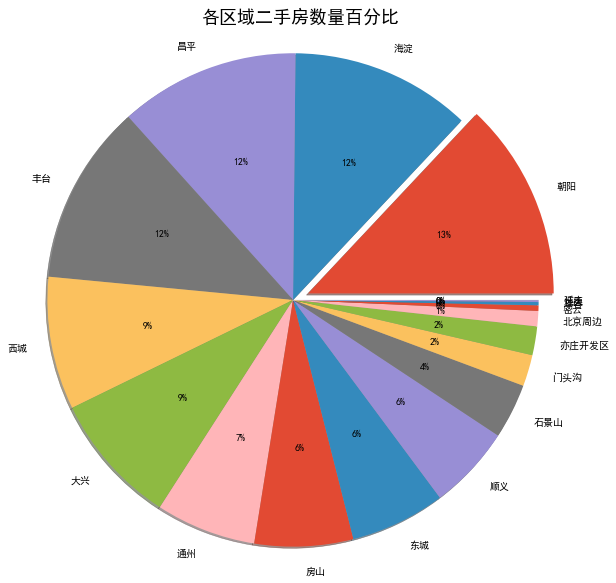

In [7]:
# 对二手房区域分组对比二手房数量和每平米房价
df_house_count = df.groupby('Region')['Price'].count().sort_values(ascending=False)
df_house_mean = df.groupby('Region')['PriceMs'].mean().sort_values(ascending=False)

#设置X轴刻度标签：
def auto_xtricks(rects,xticks):
    x = []
    for rect in rects:
        x.append(rect.get_x() + rect.get_width()/2)
    x = tuple(x)
    plt.xticks(x,xticks)

#设置数据标签：
def auto_tag(rects, data = None, offset = [0,0], size=14):
    for rect in rects:
        try:
            height = rect.get_height()
            plt.text(rect.get_x()+rect.get_width()/2.4, 1.01*height, '%s' % int(height), fontsize=size)
        except AttributeError:
            x = range(len(data))
            y = data.values
            for i in range(len(x)):
                plt.text(x[i]+offset[0],y[i]+0.05+offset[1],y[i], fontsize='14')
                
def auto_tag_float(rects, data = None, offset = [0,0], size=14):
    for rect in rects:
        try:
            height = rect.get_height()
            plt.text(rect.get_x()+rect.get_width()/2.4, 1.01*height, '%s' % round(float(height),1), fontsize=size)
        except AttributeError:
            x = range(len(data))
            y = data.values
            for i in range(len(x)):
                plt.text(x[i]+offset[0],y[i]+0.05+offset[1],y[i], fontsize='14')
    
plt.figure(figsize=(20,10))
plt.rc('font', family='SimHei', size=13)
plt.style.use('ggplot')

# 各区域二手房数量对比
plt.subplot(212)
plt.title(u'各区域二手房数量对比', fontsize=20)
plt.ylabel(u'二手房总数量（单位：间）', fontsize=15)
rect1 = plt.bar(np.arange(len(df_house_count.index)), df_house_count.values, color='c')
auto_xtricks(rect1, df_house_count.index)
auto_tag(rect1, offset=[-1,0])

# 各区域二手房平均价格对比
plt.subplot(211)
plt.title(u'各区域二手房平均价格对比', fontsize=20)
plt.ylabel(u'二手房平均价格（单位：万/平米）', fontsize=15)
rect2 = plt.bar(np.arange(len(df_house_mean.index)), df_house_mean.values, color='c')
auto_xtricks(rect2, df_house_mean.index)
auto_tag_float(rect2, offset=[-1,0])

plt.figure(figsize=(10,10))
plt.title(u'各区域二手房数量百分比', fontsize=18)
explode=[0]*len(df_house_count)
explode[0] = 0.2
plt.pie(df_house_count, radius=3, autopct='%1.f%%', shadow=True, labels=df_house_count.index, explode=explode)
plt.axis('equal')

plt.show()

### 结论：
- 二手房房数量：从数量统计上来看，可以看出目前二手房市场上比较火热的区域。朝阳区二手房数量最多，然后是海淀，毕竟大区，需求量也大。
- 二手房均价：可以看出，西城区的房价最贵均价大约**11万/平**，因为西城在二环以里，且是热门学区房的聚集地。
 其次是东城大约**10万/平**，然后是海淀大约**8.5万/平**。其它均低于**8万/平**。

### 房价和房屋面积区段的二手房数量统计

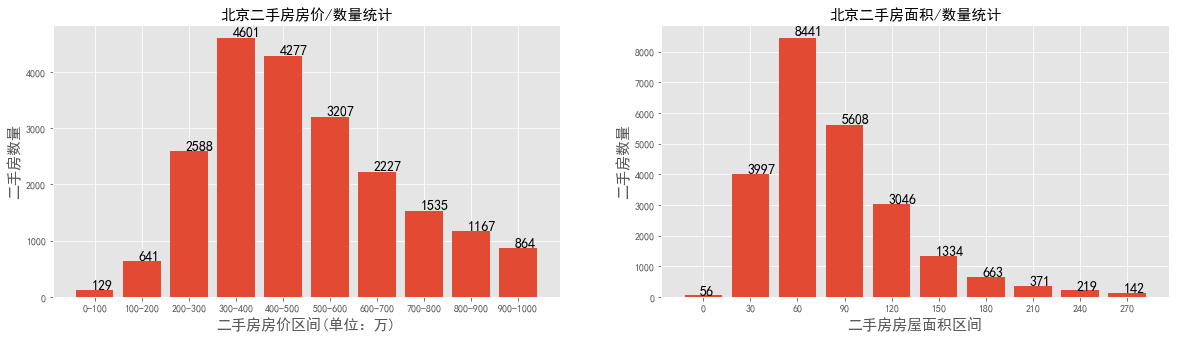

In [8]:
# 获取二手房总价的范围
def get_price_range(price, base=100):
    return '{0}-{1}'.format(int(price//base)*base, int(price//base)*base+base)

# 获取二手房面积的范围
def get_size_range(size, base=30):
    return '{0}-{1}'.format(int(size//base)*base, int(size//base)*base+base)

# 筛选房屋总价小于1000万的二手房信息进行统计
df['GroupPrice'] = df['Price'].apply(get_price_range)
df['GroupPriceSplit'] = df['GroupPrice'].str.extract('(\d+)-\d+', expand=False)
df['GroupPriceSplit'] = df['GroupPriceSplit'].astype('int')
sort_by_price_range = df.loc[df['GroupPriceSplit']<1000, ['GroupPrice','Price','GroupPriceSplit']]
sort_by_price_range.set_index('GroupPrice', inplace=True)
sort_by_price_range.sort_values(by='GroupPriceSplit', inplace=True)

# 筛选房屋面积小于300万的二手房信息进行统计
df['GroupSize'] = df['Size'].apply(get_size_range)
df['GroupSizeSplit'] = df['GroupSize'].str.extract('(\d+)-\d+', expand=False)
df['GroupSizeSplit'] = df['GroupSizeSplit'].astype('int')
sort_by_size_range = df.loc[df['GroupSizeSplit']<300, ['GroupSize','Size','GroupSizeSplit']]
sort_by_size_range.set_index('GroupSize', inplace=True)
sort_by_size_range.sort_values(by='GroupSizeSplit', inplace=True)
# display(sort_by_size_range)

# 对房价和房屋面积分组
df_group_price = sort_by_price_range.groupby('GroupPrice')['Price'].count()
df_group_size = sort_by_size_range.groupby('GroupSizeSplit')['Size'].count()

# 房价范围 vs 房屋数量可视化分析
fig_group_pirce = plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title(u'北京二手房房价/数量统计', fontsize=15)
plt.xlabel(u'二手房房价区间(单位：万)', fontsize=15)
plt.ylabel(u'二手房数量', fontsize=15)
rect_group_price = plt.bar(np.arange(len(df_group_price.index)), df_group_price.values)
auto_xtricks(rect_group_price, df_group_price.index)
auto_tag(rect_group_price, offset=[-1,0])

plt.subplot(122)
plt.title(u'北京二手房面积/数量统计', fontsize=15)
plt.xlabel(u'二手房房屋面积区间', fontsize=15)
plt.ylabel(u'二手房数量', fontsize=15)
rect_group_size = plt.bar(np.arange(len(df_group_size.index)), df_group_size.values)
auto_xtricks(rect_group_size, df_group_size.index)
auto_tag(rect_group_size, offset=[-1,0])

plt.show()

### 结论：
- 在300至400万之间的二手房数量最多，其次是400-500万之间。可以看出主要的二手房房价集中在300-500万之间，整体呈现出类似正态分布的曲线。
- 二手房房屋面积60-90平米之间的数量最多，为8441，远高出其它面积大小。其实是90-120平米，数量为5608。房屋面积集中在60-120之间，是大多数人的选择。

### 西城 & 海淀 各地方二手房房价对比

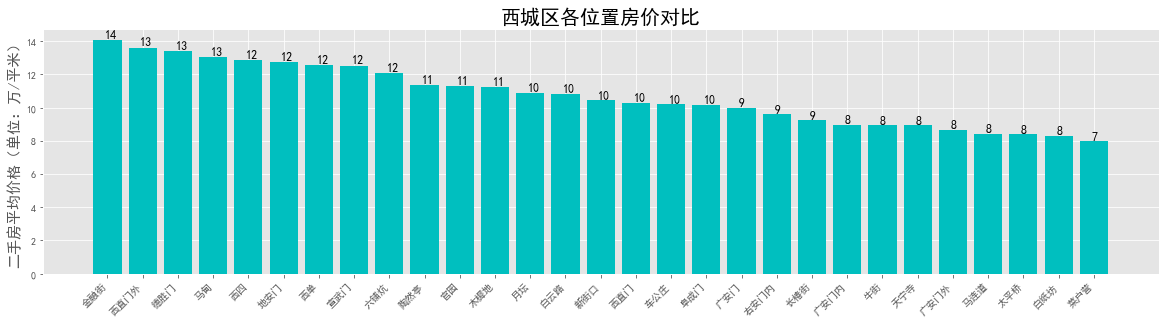

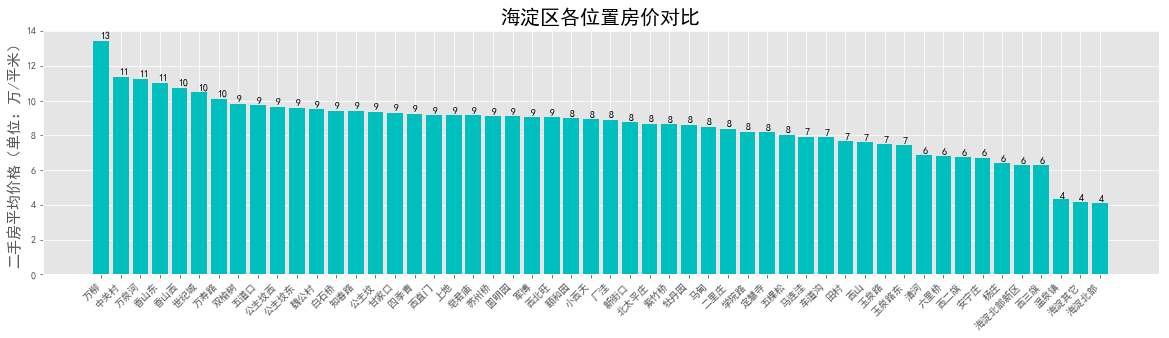

In [6]:
# 筛选区域为西城和海淀的数据
df_xicheng = df.loc[df['Region']=='西城']
df_haidian = df.loc[df['Region']=='海淀']

# 西城区个位置房价对比
fig1 = plt.figure(figsize=(20,5))
df_xicheng = df_xicheng.groupby('District')['PriceMs'].mean().sort_values(ascending=False)
rect3 = plt.bar(np.arange(len(df_xicheng.index)), df_xicheng.values, color='c')
plt.title(u'西城区各位置房价对比', fontsize=20)
plt.ylabel(u'二手房平均价格（单位：万/平米）', fontsize=15)
auto_xtricks(rect3, df_xicheng.index)
auto_tag(rect3, offset=[-1,0], size=12)
fig1.autofmt_xdate(rotation=45)

# 海淀区个位置房价对比
fig2 = plt.figure(figsize=(20,5))
df_haidian = df_haidian.groupby('District')['PriceMs'].mean().sort_values(ascending=False)
rect4 = plt.bar(np.arange(len(df_haidian.index)), df_haidian.values, color='c')
plt.title(u'海淀区各位置房价对比', fontsize=20)
plt.ylabel(u'二手房平均价格（单位：万/平米）', fontsize=15)
auto_xtricks(rect4, df_haidian.index)
auto_tag(rect4, offset=[-1,0], size=10)
fig2.autofmt_xdate(rotation=45)

plt.show()

### 结论：
- 西城区平均房价接近11万一平，而最高的价格就是金融街了，平均14万一平，毕竟是黄金地段，金融的中心。其次西直门，德胜门也是好地段，均价13万一平，学区房附近。
- 海淀区最好的房价是万柳区，平均13万一平，远高于其它地区，由于周围有好的学区。其次是中关村等地区平均约为11万一平，周围是各大互联网公司聚集地。

## 3.机器学习预测北京二手房房价

机器学习需要输入好的数据集，有意义的特征字段才能使得结果更加准确。

北京二手房房价预测项目中的数据集的特征有：
- **Size：**房屋面积，平方米
- **Layout：**房间数，间
- **Year: **房屋建造时间，年
- **Floor: **房屋所处楼层，层
- **Elevator: ** 是否有电梯
- **Renovation: ** 是否是精装修，或者简装
- **Region：**北京的区域
目标变量：
- **Price: **房屋人民币售价，万

策略方法：
- 使用**决策树**的回归模型对二手房房价进行分析预测
- 使用**交叉验证**方法充分利用数据集进行训练，避免数据划分不均匀的影响。
- 使用**GridSearchCV**方法优化模型参数
- 使用**R2**评分方法对预测打分

### - 数据清洗

可以看到，数据集中的数据类型有文本，类目，数值等。由于需要将数据集作为输入给机器学习模型计算，而数据类型统一为数值型才能计算，因此将数据类型全部转换为数值类型，以很好的为机器学习模型服务。

In [10]:
# 完善数据集，删除无意义特征，将特征数字化
drop_out = ['Garden', 'Id', 'District', 'Direction']
data = lianjia_df.drop(drop_out, axis=1)

# 汉字到数字的映射字典
loc_map = {'东城':1, '西城':2, '朝阳':3, '海淀':4, '丰台':5, '石景山':6, '通州':7, '昌平':8, '大兴':9, '亦庄开发区':10,
           '顺义':11, '房山':12, '门头沟':13, '平谷':14, '怀柔':15, '密云':16, '延庆':17, '燕郊':18, '香河':19}
renovation_map = {'简装':0, '精装':1, '其它':2}
elevator_map = {'有电梯':1, '无电梯':0}

# 数据集映射和清洗
data['Region'] = data['Region'].map(loc_map)
data['Renovation'] = data['Renovation'].map(renovation_map)
data['Elevator'] = data['Elevator'].map(elevator_map)
data['Layout'] = data['Layout'].str.extract('(^\d).*', expand=False)
data = data.dropna(how='any')

# 重新排列字段
columns1 = ['Region', 'Layout', 'Floor', 'Elevator', 'Renovation', 'Year', 'Size', 'Price']
data = pd.DataFrame(data, columns=columns1)

# 分配数据集-训练集和测试集
prices = data['Price']
features = data.drop('Price', axis = 1)
print('北京二手房房价有数据 {0} 条，字段 {1} 个。'.format(*data.shape))
data.head()

北京二手房房价有数据 12952 条，字段 8 个。


,Region,Layout,Floor,Elevator,Renovation,Year,Size,Price
1,1,2,6,0.0,1.0,1988,60.0,705.0
4,1,2,19,1.0,1.0,2010,90.0,998.0
8,1,3,9,1.0,1.0,2003,161.0,1780.0
9,1,2,25,1.0,1.0,2002,127.0,1300.0
10,1,1,5,0.0,1.0,1986,37.0,405.0


### - 数据划分
将数据集划分为训练集与测试集。

In [16]:
import numpy as np

# 转换训练测试集格式为数组
features = np.array(features)
prices = np.array(prices)

# 导入sklearn进行训练测试集划分
from sklearn.model_selection import train_test_split
features_train, features_test, prices_train, prices_test = train_test_split(features, prices, test_size=0.2, random_state=0)

### 建立模型
通过**交叉认证**缓解数据集过拟合的现象。建立决策树回归模型，通过**GridSearchCV**找到最优深度参数。

In [19]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# 利用GridSearchCV计算最优解
def fit_model(X, y):
    """ 基于输入数据 [X,y]，利于网格搜索找到最优的决策树模型"""
    
    cross_validator = KFold(10, shuffle=True)
      
    regressor = DecisionTreeRegressor()
    
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}
    
    scoring_fnc = make_scorer(performance_metric)
    
    grid = GridSearchCV(estimator = regressor, param_grid = params, scoring = scoring_fnc, cv = cross_validator)

    # 基于输入数据 [X,y]，进行网格搜索
    grid = grid.fit(X, y)
#     print pd.DataFrame(grid.cv_results_)
    return grid.best_estimator_

# 计算R2分数
def performance_metric(y_true, y_predict):
    """计算并返回预测值相比于预测值的分数"""
    from sklearn.metrics import r2_score
    score = r2_score(y_true, y_predict)

    return score

### 调参优化模型
可视化模型学习曲线，观察是否出现过拟合问题。

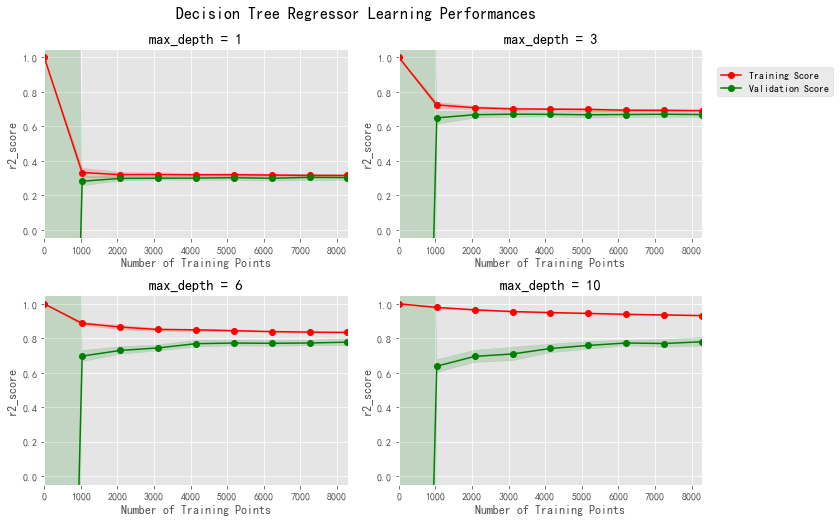

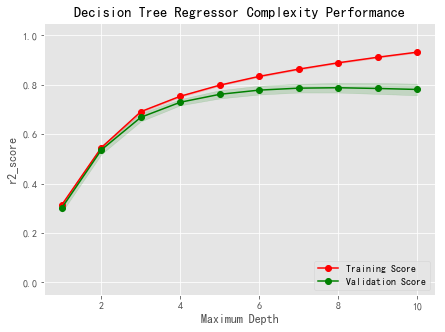

最理想模型的参数 'max_depth' 是 8 。
最优模型在测试数据上 R^2 分数 0.79。


In [21]:
import visuals as vs

# 分析模型
vs.ModelLearning(features_train, prices_train)
vs.ModelComplexity(features_train, prices_train)

optimal_reg1 = fit_model(features_train, prices_train)

# 输出最优模型的 'max_depth' 参数
print("最理想模型的参数 'max_depth' 是 {} 。".format(optimal_reg1.get_params()['max_depth']))

predicted_value = optimal_reg1.predict(features_test)
r2 = performance_metric(prices_test, predicted_value)

print("最优模型在测试数据上 R^2 分数 {:,.2f}。".format(r2))

### 结论

- 可以看到，决策树回归模型的决策深度**大约为 8 **的时候可以达到偏差与方差的平衡，也即最优模型。
- R2评分的准确率大约 **0.8**, 基本可以有效预测二手房房价。但是鉴于房价会受政策调控很大影响，因此预测结果仅供参考学习。

## 总结
本项目完成了从数据采集到数据分析，再到数据挖掘的整个数据处理过程，简单实现了北京二手房房价预测的需求。

各个阶段还有很多内容可以丰富

** - 数据采集部分：**
- 爬取更多影响房价的字段信息；
- 提高爬虫的爬取效率（尽管数据量不大）；
- 采集更多房屋中间商数据，补充数据集；

** - 数据分析部分：**
- 需要更深入研究特征信息对目标值的影响；
- 分析北京二手房房价的走势；
- 分析北京二手房房价的供需趋势；

** - 数据挖掘部分：**

为了使得预测更加准确，还有很多优化的地方，包括：
- 分析异常值，清除异常值或者填补异常值（随即森林拟合填补）；
- 爬虫或其他途径寻找更多对房价有影响的特征，例如附近是否有学区房，是否靠近地铁；
- 尝试其它更好模型，对比各个模型预测结果，选取最优模型；